## Code to verify ERA5 and WRF simulations against Copernicus Scatterometer Observations:

#### Loading Python modules:

In [56]:
import numpy as np
import numpy 
from netCDF4 import Dataset
import csv
import glob 
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap
from scipy.ndimage.filters import gaussian_filter
from wrf import ALL_TIMES
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
cartopy_ylim, latlon_coords)
from wrf import getvar, interplevel, interpz3d
import matplotlib.colors as mcolors
import pygrib
import cfgrib
import datetime
from datetime import datetime
from datetime import datetime, timedelta
from scipy.interpolate import griddata
import pickle

#### Enter to the work directory where the figures will be stored:

In [3]:
cd /hpcperm/bidc/Project_Spgrflao/Paper/Plots/Verifications_Copernicus_Scatterometers

/lus/h2resw01/hpcperm/bidc/Project_Spgrflao/Paper/Plots/Verifications_Copernicus_Scatterometers


### Defining some functions:

#### Defining function to obtain initial and end date for each cyclone:

In [48]:
def get_cyclone_dates(folder_wrf_path, cyc_num):
    
    # Listing sorted WRF files:
    file_name_d01 = folder_wrf_path+'medCYC_{:04d}_d01*_00_00'.format(cyc_num)
    file_name_d02 = folder_wrf_path+'medCYC_{:04d}_d02*_00_00'.format(cyc_num)
    files_d01 = np.sort(glob.glob(file_name_d01))
    files_d02 = np.sort(glob.glob(file_name_d02))
    
    # Initialize variables to store the earliest and latest dates
    earliest_date = None
    latest_date = None

    # Loop through the filenames
    for file_name in files_d02:
        # Extract the date part from the filename
        parts = file_name.split('_')
        date_str = parts[4] + ' ' + parts[5]  + parts[6] + parts[7] # Combine date and time parts
        # Convert the string to a datetime object
        date = datetime.strptime(date_str, '%Y-%m-%d %H%M%S')

        # Update earliest and latest dates
        if earliest_date is None or date < earliest_date:
            earliest_date = date
        if latest_date is None or date > latest_date:
            latest_date = date

    # Print the results
    print("Earliest date:", earliest_date)
    print("Latest date:", latest_date)

    return files_d01,files_d02, earliest_date, latest_date

#### Defining function to create hourly dates from the first initial date to the final date:

In [49]:
def generate_dates(earliest_date, latest_date):
    # Define the start and end dates
    start_date = earliest_date
    end_date = latest_date

    # Initialize the current date as the start date
    current_date = start_date

    # List to hold all the dates
    date_list = []

    # Loop through from start date to end date
    while current_date <= end_date:
        date_list.append(current_date)
        # Increment the current date by one hour
        current_date += timedelta(hours=1)
    
    return(date_list)

#### Defining function to compute RMSE:

In [32]:
def calculate_rmse(observed, predicted):
    """
    Calculate the root mean squared error between two numpy arrays.

    Parameters:
    observed (np.array): A numpy array of observed values.
    predicted (np.array): A numpy array of predicted values.

    Returns:
    float: The RMSE between the observed and predicted values.
    """
    # Ensure observed and predicted are numpy arrays
    observed = np.array(observed)
    predicted = np.array(predicted)

    # Check that dimensions match
    if observed.shape != predicted.shape:
        raise ValueError("The dimensions of the input arrays must match.")
    
    # Create a mask to filter out NaN values in either observed or predicted
    mask = ~np.isnan(observed) & ~np.isnan(predicted)

    # Apply the mask
    observed_filtered = observed[mask]
    predicted_filtered = predicted[mask]
    
    # Calculate the differences and square them
    squared_differences = (observed_filtered - predicted_filtered) ** 2

    # Calculate the mean of the squared differences
    mean_squared_differences = np.mean(squared_differences)

    # Calculate the square root of the mean squared differences to get the RMSE
    rmse = np.sqrt(mean_squared_differences)

    return rmse

#### Obtaining variables of interest from ERA5 and WRF simulations [Single Test]:

In [4]:
cyc_num              = 20

#
# Loading dataset from ERA5 and WRF simulations:
#
#folder_era5_wrf_path = '../ERA5_Inter_WRF_Cyclones/'
folder_era5_wrf_path = '/scratch/bidc/DCC/ERA5_Inter_WRF_Cyclones/'
file_name            = folder_era5_wrf_path+'wspeed_ERA5_Interpolation2WRF_Cyc_{:04d}_binary'.format(cyc_num)
binary_file          = open(file_name,"rb")
dataset_models       = pickle.load(binary_file)
dataset_models.keys()

#
# Loading dataset from Copernicus Observations:
#
folder_obs_path = '../Copernicus_Obs/'
file_name       = folder_obs_path+'wspeed_Copernicus_Interpolation2WRF_Cyc_{:04d}_binary'.format(cyc_num)
binary_file     = open(file_name,"rb")
dataset_obs     = pickle.load(binary_file)
dataset_obs.keys()

#
# Obtaining variables of interest:
#

tt          = 20     # Defining time step of interst

lat         = dataset_models['lat'][tt,:,:]
lon         = dataset_models['lon'][tt,:,:]
ws_wrf_d01  = dataset_models['ws_interp_wrf_d01'][tt,:,:]
ws_wrf_d02  = dataset_models['wind_speed_wrf_d02'][tt,:,:]
ws_era5     = dataset_models['ws_interp_era5'][tt,:,:]
ws_obs      = dataset_obs['ws_interp_copernicus'][tt,:,:]


dict_keys(['ws_interp_era5', 'ws_interp_wrf_d01', 'wind_speed_wrf_d02', 'lat', 'lon'])

#### Creating Basemap:

In [7]:
proj, moad_cen_lat, cen_lat, cen_lon, truelat1, truelat2, standlon = "lcc", 38, 38, 12, 34, 36, 12
#x_dim, y_dim = 650, 350
x_dim, y_dim = 350, 250
dx, dy = 9000, 9000
width_meters, height_meters = dx * (x_dim - 1), dy * (y_dim - 1) 
    
m_d01 = Basemap(resolution="h",projection=proj,rsphere=6370000.,width=width_meters,height=height_meters,lat_0=cen_lat,lon_0=cen_lon,lat_1=truelat1,lat_2=truelat2,area_thresh=100.) 

#### Plotting Figure:

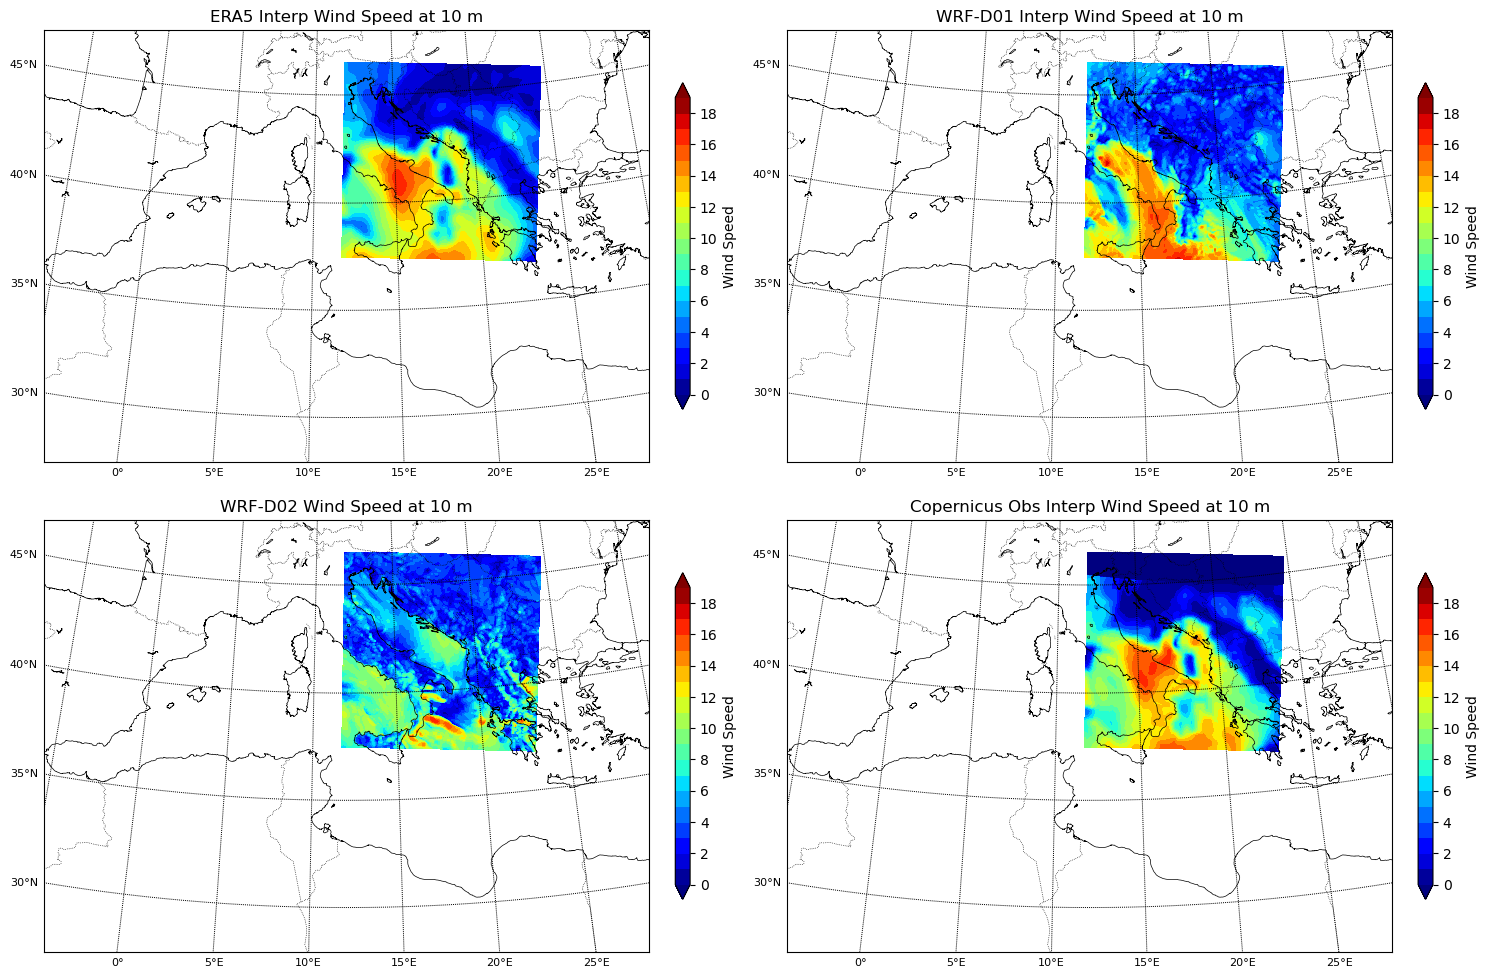

In [66]:
# Plotting map:
from matplotlib import cm
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(221)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
clevs=np.arange(0,20,1)
cs1 = m_d01.contourf(x,y,ws_era5,clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('ERA5 Interp Wind Speed at 10 m')
#
ax = fig.add_subplot(222)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
#clevs=np.arange(0,14,2)
cs1 = m_d01.contourf(x,y,ws_wrf_d01,clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('WRF-D01 Interp Wind Speed at 10 m')
#
ax = fig.add_subplot(223)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
#clevs=np.arange(0,14,2)
cs1 = m_d01.contourf(x,y,ws_wrf_d02,clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('WRF-D02 Wind Speed at 10 m')
#
ax = fig.add_subplot(224)
parallels = np.arange(-90,90,5)
meridians = np.arange(0,360,5)
m_d01.drawcoastlines(color="black",linewidth=0.5)
m_d01.drawstates(linestyle="dotted")
m_d01.drawcountries(linestyle="dotted")
m_d01.drawparallels(parallels,labels=[1,0,0,0],fontsize=8,linewidth=.7)
m_d01.drawmeridians(meridians,labels=[0,0,0,1],fontsize=8,linewidth=.7)
x, y = m_d01(lon,lat) # compute map proj coordinates of the grid points
#clevs=np.arange(0,14,2)
#cs1 = m_d01.contourf(x,y,ws_obs[tt,:,:],cmap=plt.cm.jet,extend='both')
ws_obs_nnans = np.nan_to_num(ws_obs, nan=0)
cs1 = m_d01.contourf(x,y,ws_obs_nnans,clevs,cmap=plt.cm.jet,extend='both')
plt.colorbar(cs1, label= 'Wind Speed',fraction=0.023,pad=0.04)
fig.tight_layout()
plt.title('Copernicus Obs Interp Wind Speed at 10 m')
fig.subplots_adjust(wspace=0.15, hspace=-0.5)  # Adjust the vertical space between the subplots
fig.savefig('Verification_Test.png',dpi=300)


#### Computing RMSE associated to 10m Wind Speed:

In [63]:
cyc_num              = 8

#
# Loading dataset from ERA5 and WRF simulations:
#
#folder_era5_wrf_path = '../ERA5_Inter_WRF_Cyclones/'
folder_era5_wrf_path = '/scratch/bidc/DCC/ERA5_Inter_WRF_Cyclones/'
file_name            = folder_era5_wrf_path+'wspeed_ERA5_Interpolation2WRF_Cyc_{:04d}_binary'.format(cyc_num)
binary_file          = open(file_name,"rb")
dataset_models       = pickle.load(binary_file)
dataset_models.keys()

#
# Loading dataset from Copernicus Observations:
#
folder_obs_path = '../Copernicus_Obs/'
file_name       = folder_obs_path+'wspeed_Copernicus_Interpolation2WRF_Cyc_{:04d}_binary'.format(cyc_num)
binary_file     = open(file_name,"rb")
dataset_obs     = pickle.load(binary_file)
dataset_obs.keys()

#
# Obtaining variables of interest:
#
# Obtaining time steps for each cyclone case:
time_steps = np.shape(dataset_models['wind_speed_wrf_d02'])[0]

# Initializing variables:
rmse_era5_interp     = np.zeros(shape=(time_steps,1))
rmse_wrfd01_interp   = np.zeros(shape=(time_steps,1))
rmse_wrfd02          = np.zeros(shape=(time_steps,1))

# Looping over all time steps:
for tt in range(0,time_steps):
    lat                = dataset_models['lat'][tt,:,:]
    lon                = dataset_models['lon'][tt,:,:]
    ws_wrf_d01_interp  = dataset_models['ws_interp_wrf_d01'][tt,:,:]
    ws_wrf_d02         = dataset_models['wind_speed_wrf_d02'][tt,:,:]
    ws_era5_interp     = dataset_models['ws_interp_era5'][tt,:,:]
    ws_obs_interp      = dataset_obs['ws_interp_copernicus'][tt,:,:]
    #
    # Computing RMSE:
    #
    rmse_era5_interp[tt,:]   = calculate_rmse(ws_obs_interp, ws_era5_interp)
    rmse_wrfd01_interp[tt,:] = calculate_rmse(ws_obs_interp, ws_wrf_d01_interp)
    rmse_wrfd02[tt,:]        = calculate_rmse(ws_obs_interp, ws_wrf_d02)

#print('rmse_era5: ',   rmse_era5_interp )
#print('rmse_wrfd01: ', rmse_wrfd01_interp )
#print('rmse_wrfd02: ', rmse_wrfd02 )

In [64]:
print('CYCLONE NUMBER: ', cyc_num)
    
folder_era5_path = '/scratch/bidc/DCC/CYC_{:01d}/'.format(cyc_num)
folder_wrf_path = '/scratch/bidc/DCC/medTRACK_{:04d}/'.format(cyc_num)

# Select range of times for each Cyclone simulation:
[files_d01,files_d02, earliest_date,latest_date] = get_cyclone_dates(folder_wrf_path, cyc_num)

# Generate Dates every hour:
date_list = generate_dates(earliest_date,latest_date)

# Converting datetime objects to formatted strings
formatted_dates = [dt.strftime('%Y-%m-%d %H:%M') for dt in date_list]

CYCLONE NUMBER:  8
Earliest date: 2012-04-12 12:00:00
Latest date: 2012-04-14 20:00:00


#### Plotting RMSE:

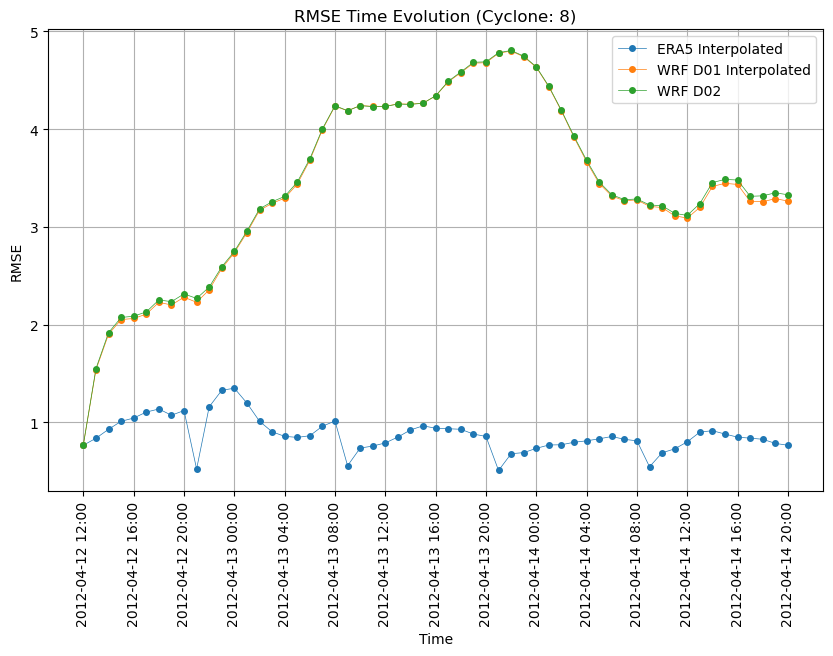

In [69]:
# Create a plot
fig = plt.figure(figsize=(10, 6))

# Assuming time_steps is a range or list of time points
time_points = np.arange(time_steps)

# Plotting each RMSE series
plt.plot(time_points, rmse_era5_interp, label='ERA5 Interpolated', marker='o',ms=4,linewidth=0.5)
plt.plot(time_points, rmse_wrfd01_interp, label='WRF D01 Interpolated', marker='o',ms=4,linewidth=0.5)
plt.plot(time_points, rmse_wrfd02, label='WRF D02', marker='o',ms=4,linewidth=0.5)

# Adding titles and labels
plt.title('RMSE Time Evolution (Cyclone: '+ str(cyc_num) +')')
plt.xlabel('Time')
plt.ylabel('RMSE')

# Setting x-axis tick labels
plt.xticks(time_points[::4], formatted_dates[::4], rotation=90)  # Rotate labels for better visibility

# Adding a legend to clarify which line corresponds to which dataset
plt.legend()

# Optionally adding a grid for easier reading
plt.grid(True)

# Show the plot
plt.show()
fig.savefig('RMSE_Cyclone8_Test.png',dpi=300)
